### import the packages

In [ ]:
# Python packages we need
import os
import pathlib
from pathlib import Path
import datetime
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import PIL
import PIL.Image

%matplotlib inline
import shutil #file operations
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator #generate images from an image


### GPU

In [ ]:
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')
# #tf.config.set_visible_devices([], 'GPU')

### Get the datat and zip it

In [ ]:
! git clone https://github.com/minus--/arabic-letters-tutorial

In [ ]:
! tar xvzf arabic-letters-tutorial/arabic_handwritten_data.tgz # unzip

### creating new folders for the train and test data
where we can generate and save the different images from each image corresponding to a letter

In [ ]:
mkdir data/new_data

In [ ]:
mkdir data/new_data/test_data

In [ ]:
mkdir data/new_data/train_data

### creating 28 folder for the 28 arabic letters

In [ ]:
for i in range(1,29):
  os.mkdir("data/new_data/test_data/{}".format(i))
  os.mkdir("data/new_data/train_data/{}".format(i))

In [ ]:
directory_train = "./data/train_data/"
images_train = os.listdir(directory_train) #return a list containing the names of the entries in the directory of train data
directory_test = "./data/test_data/"
images_test = os.listdir(directory_test) #return a list containing the names of the entries in the directory of test data

### copying images from the source data train set to the target which is the new folder 

In [ ]:
for image in images_train:
  if image.endswith('.png'):
    label =int(tf.strings.regex_replace(input=image,pattern=r".+_label_(\d+)\.png",rewrite =r"\1").numpy())
    original = directory_train+image
    target =("./data/new_data/train_data/{}/".format(label))+image
    shutil.copy2(original,target) #to target

### copying images from the source data test set to the target which is the new folder 

In [ ]:
for image in images_test:
  if image.endswith('.png'):
    label =int(tf.strings.regex_replace(input=image,pattern=r".+_label_(\d+)\.png",rewrite =r"\1").numpy())
    original = directory_test+image
    target =("./data/new_data/test_data/{}/".format(label))+image
    shutil.copy2(original,target) #to target

### The scaling and the creation of the layers

In [ ]:
training_dir = "data/new_data/train_data/"
# generate more images from each folder of every arabic letter by imagedatagenerator
training_datagen = ImageDataGenerator( 
      rescale = 1./255, #rescaling 1/255 because the max pixel value is 255 & we want a value between 0 & 1
	    rotation_range=40,  # max rotation degree is 40°
      width_shift_range=0.2, #percentage of the shift to the sides
      height_shift_range=0.2, #percentage of the shift to the top and to the bottom
      shear_range=0.2, # image will be distorted along an axis in image augmentation
      zoom_range=0.2, #zoom in and zoom out
      horizontal_flip=True, # we allow horizontal flip
      fill_mode='nearest') #fill the area with the nearest pixel and stretch it.

validation_dir = "data/new_data/test_data/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	training_dir,
	target_size=(32,32),
	class_mode='categorical',
  batch_size=32 #by default
)

validation_generator = validation_datagen.flow_from_directory(
	validation_dir,
	target_size=(32,32),
	class_mode='categorical',
  batch_size=32
)

model = tf.keras.models.Sequential([
    # first convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding="same", input_shape=(32, 32, 3)), #64*3*3 convolution
    tf.keras.layers.MaxPooling2D(2, 2), #we could also use avrgpooling but now we use maxpooling 2*2
    # second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding="same"), #64*3*3 convolution
    tf.keras.layers.MaxPooling2D(2,2),
    # third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"), #128*3*3 convolution
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"), #128*3*3 convolution
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to giveto  a CNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.7),  #we will see results before & after dropout
    # 512 neuron hidden layer = output layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(28, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, epochs=50, steps_per_epoch=420, validation_data = validation_generator, verbose = 1, validation_steps=105)

model.save("rps.h5")

Found 13440 images belonging to 28 classes.
Found 3360 images belonging to 28 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________

with only 25 epoch and 20 steps by epoch we reached maximum accuracy of 0.3016 and a loss value of 2.3259 so we need to increase the number of epochs and the number of steps per epoch. And that makes more sens since we have a large number of data set and we also have generated images with Imagedatagenerator. We want to train the data to get to the maximum accuracy and the least loss possible.

The accurancy in the ANN model is 0.7789 and in the CNN is 0.8250 with a loss value of 0.5541 

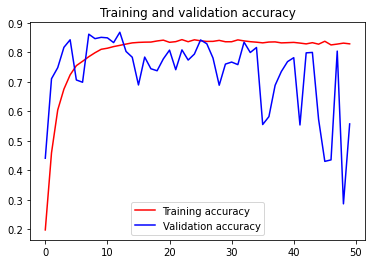

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()